In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [10]:
def load_results_dataframe(dir: Path, pattern: str) -> pd.DataFrame:
    """
    Walks dir for files named 'episodes_*.json', loads them,
    and returns a single DataFrame with columns:
      - all keys from your JSON records
      - 'source_file': the filename each record came from
      - 'modified_time': a pandas.Timestamp of the file’s mtime
    
    Rows are sorted by modified_time (most recent first).
    """
    records = []
    
    # grab all matching files, then sort by mtime descending
    files = sorted(
        dir.glob(pattern),
        key=lambda p: p.stat().st_mtime,
        reverse=True
    )
    
    for path in files:
        mtime = pd.to_datetime(path.stat().st_mtime, unit="s")
        with path.open("r") as fp:
            content = json.load(fp)
        
        # If the JSON is a list of dicts, expand each entry...
        if isinstance(content, list):
            for entry in content:
                rec = dict(entry)  # shallow copy
                rec["source_file"]   = path.name
                rec["modified_time"] = mtime
                records.append(rec)
        # If it’s a single dict, just one row
        elif isinstance(content, dict):
            rec = dict(content)
            rec["source_file"]   = path.name
            rec["modified_time"] = mtime
            records.append(rec)
        else:
            # fallback: stash raw content
            records.append({
                "source_file": path.name,
                "modified_time": mtime,
                "data": content
            })
    
    # build the DataFrame
    df = pd.DataFrame(records)
    # ensure sorted by modified_time
    df.sort_values("modified_time", ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def load_episodes_dataframe(dir: Path) -> pd.DataFrame:
    return load_results_dataframe(dir=dir, pattern="episodes_*.json")

In [ ]:
training_dir = Path("./outputs/1753592624458505983")

In [19]:
training_params = json.load(open(training_dir / "training_params.json", "r"))
for k, v in training_params.items():
    print(f"{k}: {v}")

n_episodes: 5000000
pretrained_dir: None
seed: 42
learning_rate_max: 0.5
learning_rate_min: 0.01
learning_rate_decay_rate: 0.99
epsilon_max: 1.0
epsilon_min: 0.1
epsilon_decay_rate: 0.99
opponent: RANDOM_AGENT
training: 2


In [ ]:
episodes = load_episodes_dataframe(training_dir)
episodes.head()

,n_updates,mean_td_error,mean_abs_td_error,mean_squared_td_error,max_abs_td_error,final_reward,source_file,modified_time
0,2,0.000000,0.000000,0.000000,0.000000,-1.0,episodes_0.json,2025-07-27 05:03:44.465080500
1,2,0.022055,0.022055,0.000907,0.042573,-1.0,episodes_500000.json,2025-07-27 05:04:48.785615683
2,2,-0.318722,0.326080,0.207912,0.644802,-1.0,episodes_500000.json,2025-07-27 05:04:48.785615683
3,4,0.052569,0.052569,0.010809,0.207915,-0.0,episodes_500000.json,2025-07-27 05:04:48.785615683
4,4,0.250827,0.251421,0.222185,0.941480,1.0,episodes_500000.json,2025-07-27 05:04:48.785615683


In [13]:
len(episodes)

5000000

In [14]:
def get_moving_window_average(data: np.ndarray, window_size: int):
    weights = np.ones(window_size) / window_size
    moving_avg = np.convolve(data, weights, mode='valid')
    return moving_avg

Text(0.5, 1.0, 'final reward moving window average')

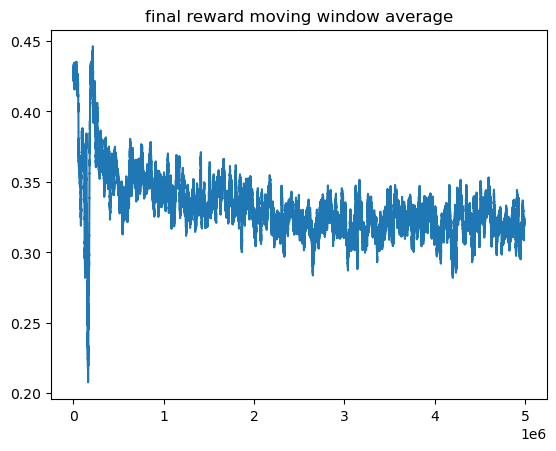

In [16]:
plt.plot(get_moving_window_average(episodes["final_reward"], window_size=10000))
plt.title("final reward moving window average")